# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [396]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [397]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data wrangling

# Data wrangling Portfolio

In [398]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [399]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [400]:
portfolio.isnull().isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [401]:
portfolio.shape

(10, 6)

In [402]:
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


# Datawrangling profile

In [403]:
profile.shape

(17000, 5)

In [404]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [405]:
profile['gender'].fillna((profile['gender'].mode()[0]), inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [406]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [407]:
profile.isnull().sum().sum()

0

In [408]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65404.991568


In [409]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65404.991568


In [410]:
profile = profile.rename(columns={'id':'customer_id'})
profile.head(2)

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000


# Data wrangling Transcript

In [411]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [412]:
#Revisist this code
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]
transcript=transcript.rename(columns={'person':'customer_id'})
transcript=transcript.drop(columns='value')
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [413]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [414]:
transcript.isnull().sum().sum()

306534

# Merge Raw Dataframes

In [457]:
df1= pd.merge(transcript, profile, on='customer_id')
df1.head(1)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,age,gender,income,F,M,O,2013,2014,2015,2016,2017,2018
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,F,100000.0,1,0,0,0,0,0,0,1,0


In [453]:
df2 = pd.merge(df1,portfolio, on='offer_id', how='left')
pd.set_option('display.max_columns',None)
df2.head(1)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,age,gender,income,F,M,O,2013,2014,2015,2016,2017,2018,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,F,100000.0,1,0,0,0,0,0,0,1,0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [460]:
df2.shape

(306534, 33)

In [461]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 33 columns):
event              306534 non-null object
customer_id        306534 non-null object
time               306534 non-null int64
offer_id           167581 non-null object
amount             138953 non-null float64
offer completed    306534 non-null uint8
offer received     306534 non-null uint8
offer viewed       306534 non-null uint8
transaction        306534 non-null uint8
age                306534 non-null int64
gender             306534 non-null object
income             306534 non-null float64
F                  306534 non-null uint8
M                  306534 non-null uint8
O                  306534 non-null uint8
2013               306534 non-null uint8
2014               306534 non-null uint8
2015               306534 non-null uint8
2016               306534 non-null uint8
2017               306534 non-null uint8
2018               306534 non-null uint8
channels           1

In [463]:
df2.columns[df2.isnull().sum()/df2.shape[0]*100>25]

Index(['offer_id', 'amount', 'channels', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational'],
      dtype='object')

# One Hot Encoding

In [417]:
#Onehot encoding Portfolio

In [418]:
#Code source Udacity Mentor ,https://knowledge.udacity.com/questions/567811
#Creating dummy variable for channel
mlb = MultiLabelBinarizer()
channel_d = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)
channel_d.head(1)

,email,mobile,social,web
0,1,1,1,0


In [419]:
#creating dummy variable for offer
offer_d=pd.get_dummies(portfolio.offer_type)
offer_d.head(1)

,bogo,discount,informational
0,1,0,0


In [420]:
#Concatinate Channel and offer dummies with portfolio
portfolio = pd.concat([portfolio, channel_d, offer_d], axis=1)
portfolio=portfolio.rename(columns={'id':'offer_id'})
portfolio.head(1)

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0


In [421]:
#onehot encoding profile

In [422]:
gender_d=pd.get_dummies(profile.gender)
gender_d.head(1)

,F,M,O
0,0,1,0


In [423]:
#One Hot encoding of "became_member_on" column of Profile dataset. Here I want to extrat Year and create columns for just 
#those years. 
profile['year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile.head(1)

,age,became_member_on,gender,customer_id,income,year
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017


In [424]:
year_d=pd.get_dummies(profile.year)
year_d.head(1)

,2013,2014,2015,2016,2017,2018
0,0,0,0,0,1,0


In [425]:
profile = pd.concat([profile, gender_d, year_d], axis=1)
profile=profile.rename(columns={'id':'customer_id'})

profile.head(1)

,age,became_member_on,gender,customer_id,income,year,F,M,O,2013,2014,2015,2016,2017,2018
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,0,1,0,0,0,0,0,1,0


In [426]:
profile= profile.loc[:,~profile.columns.duplicated()]
profile=profile.drop(['became_member_on','year'],axis=1)
profile.head(1)

,age,gender,customer_id,income,F,M,O,2013,2014,2015,2016,2017,2018
0,118,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,1,0,0,0,0,0,1,0


In [427]:
#Onehot encoding of Transcript

In [428]:
# event dummies

event_d=pd.get_dummies(transcript.event)

transcript = pd.concat([transcript, event_d], axis=1)
transcript = transcript.rename(columns={'person':'id'})

transcript.head(1)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0


In [429]:
transcript= transcript.loc[:,~transcript.columns.duplicated()]
transcript.head(1)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0


# Merge onehot encoded Dataframes

In [430]:
df1= pd.merge(transcript, profile, on='customer_id')
df1.head(1)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,age,gender,income,F,M,O,2013,2014,2015,2016,2017,2018
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,F,100000.0,1,0,0,0,0,0,0,1,0


In [431]:
df2 = pd.merge(df1,portfolio, on='offer_id', how='left')
pd.set_option('display.max_columns',None)
df2.head(1)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,age,gender,income,F,M,O,2013,2014,2015,2016,2017,2018,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,F,100000.0,1,0,0,0,0,0,0,1,0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


# Create two seperate data frame for Offers and transaction

In [432]:
df3=df2.query('event=="transaction"')
df3.head(4)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,age,gender,income,F,M,O,2013,2014,2015,2016,2017,2018,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,0,0,0,1,75,F,100000.0,1,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,0,0,0,1,75,F,100000.0,1,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67,0,0,0,1,75,F,100000.0,1,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72,0,0,0,1,75,F,100000.0,1,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [540]:
df3.duplicated().sum()

0

In [434]:
#df4=df2.query('event !="transaction"')
#df4.head(2)

df4=df2.query('event !="transaction"')
df4['channels'] = df4['channels'].apply(lambda x : ','.join(x))
df4.duplicated().sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


397

In [435]:
df4=df4.drop_duplicates(subset=None, keep='first', inplace=False)

In [436]:
df4.duplicated().sum()

0

In [437]:
df4.head(2)

,event,customer_id,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,age,gender,income,F,M,O,2013,2014,2015,2016,2017,2018,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,F,100000.0,1,0,0,0,0,0,0,1,0,"web,email,mobile",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,75,F,100000.0,1,0,0,0,0,0,0,1,0,"web,email,mobile",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


# DATA EXPLORATION

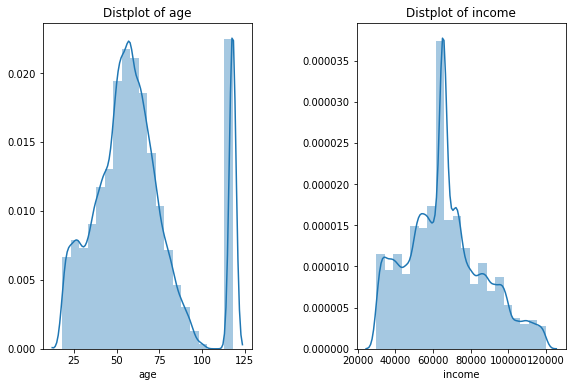

In [438]:
plt.figure(1,figsize=(15,6))
n=0
for x in['age','income']:
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df4[x],bins=20)
    plt.title('Distplot of {}'.format(x))
plt.show()

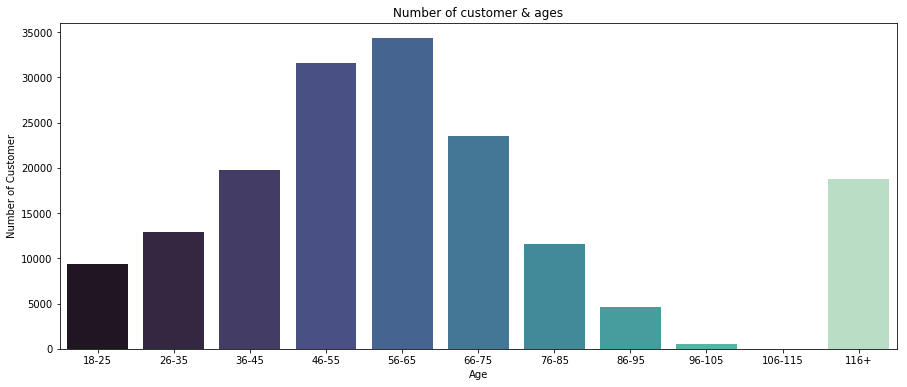

In [439]:
age_18_25 = df4.age[(df4.age>=18) & (df4.age<=25)]
age_26_35 = df4.age[(df4.age>=26) & (df4.age<=35)]
age_36_45 = df4.age[(df4.age>=36) & (df4.age<=45)]
age_46_55 = df4.age[(df4.age>=46) & (df4.age<=55)]
age_56_65 = df4.age[(df4.age>=56) & (df4.age<=65)]
age_66_75 = df4.age[(df4.age>=66) & (df4.age<=75)]
age_76_85 = df4.age[(df4.age>=76) & (df4.age<=85)]
age_86_95 = df4.age[(df4.age>=86) & (df4.age<=95)]
age_96_105  = df4.age[(df4.age>=96) & (df4.age<=105)]
age_106_115  = df4.age[(df4.age>=106) & (df4.age<=115)]
age_116above  = df4.age[df4.age>=116]
agex=["18-25","26-35","36-45","46-55","56-65","66-75","76-85","86-95","96-105","106-115","116+"]
agey=[len(age_18_25.values),len(age_26_35.values),len(age_36_45.values),len(age_46_55.values),len(age_56_65.values),
      len(age_66_75.values),len(age_76_85.values),len(age_86_95.values),len(age_96_105.values),len(age_106_115.values),
      len(age_116above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=agex,y=agey,palette="mako")
plt.title("Number of customer & ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

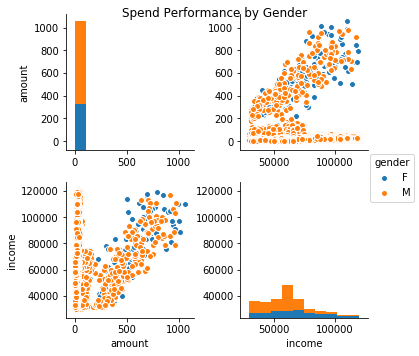

In [440]:
df=df3[['gender','amount','income']].query('gender in ["F","M"]')

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Spend Performance by Gender");


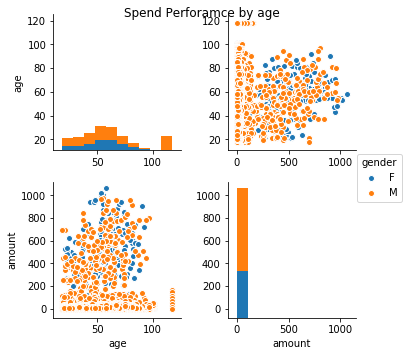

In [441]:
df=df3[['gender','age','amount']].query('gender in ["F","M"]')

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Spend Perforamce by age");

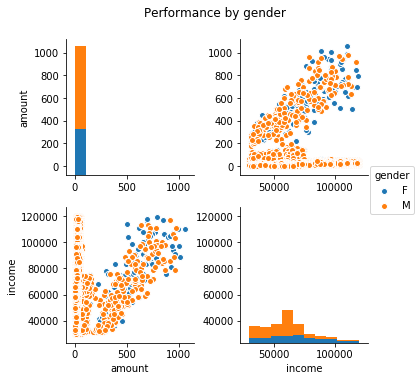

In [442]:
df=df3[['gender','amount','income']].query('gender in ["F","M"]')

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Performance by gender", y=1.05);

In [443]:
df = df4[['customer_id','gender', 'age']]
df.duplicated().sum()

150190

In [444]:
df=df.drop_duplicates(subset=None, keep='first', inplace=False)

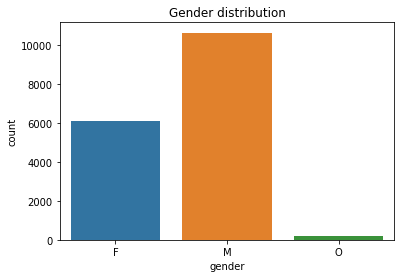

In [445]:
ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

[Text(0,0.5,'Count'), Text(0.5,0,''), Text(0.5,1,'Informational')]

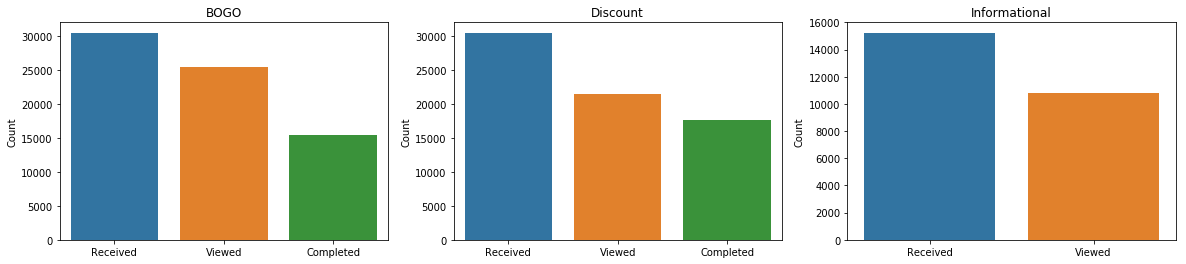

In [475]:

df = df4.groupby(['event', 'offer_type'])['customer_id'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='customer_id', data=df.query('offer_type == "bogo"'),  ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='customer_id', data=df.query('offer_type == "discount"'), ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='customer_id', data=df.query('offer_type == "informational"'), ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

#fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

In [508]:
offer_received = df4[df4['offer received'] == 1].offer_type.value_counts().sum()
Offer_viewed = df4[df4['offer viewed'] == 1].offer_type.value_counts().sum()
Offer_completed = df4[df4['offer completed'] == 1].offer_type.value_counts().sum()


In [521]:
offer_received=df4.groupby('bogo')['offer received'].value_counts()
offer_viewed=df4.groupby('bogo')['offer viewed'].value_counts()
offer_completed=df4.groupby('bogo')['offer completed'].value_counts()

eff_bogo1=offer_viewed/offer_received*100
eff_bogo2=offer_completed/offer_viewed*100

eff_bogo1;eff_bogo2

bogo  offer completed
0.0   0                  122.999102
      1                   54.780642
1.0   0                  121.626087
      1                   60.910055
dtype: float64

In [522]:
offer_received=df4.groupby('discount')['offer received'].value_counts()
offer_viewed=df4.groupby('discount')['offer viewed'].value_counts()
offer_completed=df4.groupby('discount')['offer completed'].value_counts()

eff_discount1=offer_viewed/offer_received*100
eff_discount2=offer_completed/offer_viewed*100

eff_discount1;eff_discount2

discount  offer completed
0.0       0                  133.933208
          1                   42.726020
1.0       0                  107.805242
          1                   82.448123
dtype: float64

# Further Data Cleaning

In [447]:
pd.set_option('display.max_columns',None)
df5=df4.drop_duplicates(subset=None, keep='first', inplace=False)
df5 = df5.drop(df4[(df4.age > 100)].index)
df5 = df5.drop('offer_type',axis=1)
df5 = df5.drop('amount',axis=1)
df5 = df5.drop('channels',axis=1)
df5 = df5.drop('gender',axis=1)
df5 = df5.drop('event',axis=1)
df5 = df5.drop('offer_id',axis=1)
df5=df5.drop('time',axis=1)
df5=df5.drop(columns=['customer_id'])

df5.head(4)

,offer completed,offer received,offer viewed,transaction,age,income,F,M,O,2013,2014,2015,2016,2017,2018,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,0,1,0,0,75,100000.0,1,0,0,0,0,0,0,1,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,1,0,75,100000.0,1,0,0,0,0,0,0,1,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0,0,0,75,100000.0,1,0,0,0,0,0,0,1,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5,0,1,0,0,75,100000.0,1,0,0,0,0,0,0,1,0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [448]:
df5.duplicated().sum()

31516

In [449]:
df5=df5.drop_duplicates(subset=None, keep='first', inplace=False)

In [450]:
df5.shape

(116864, 25)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


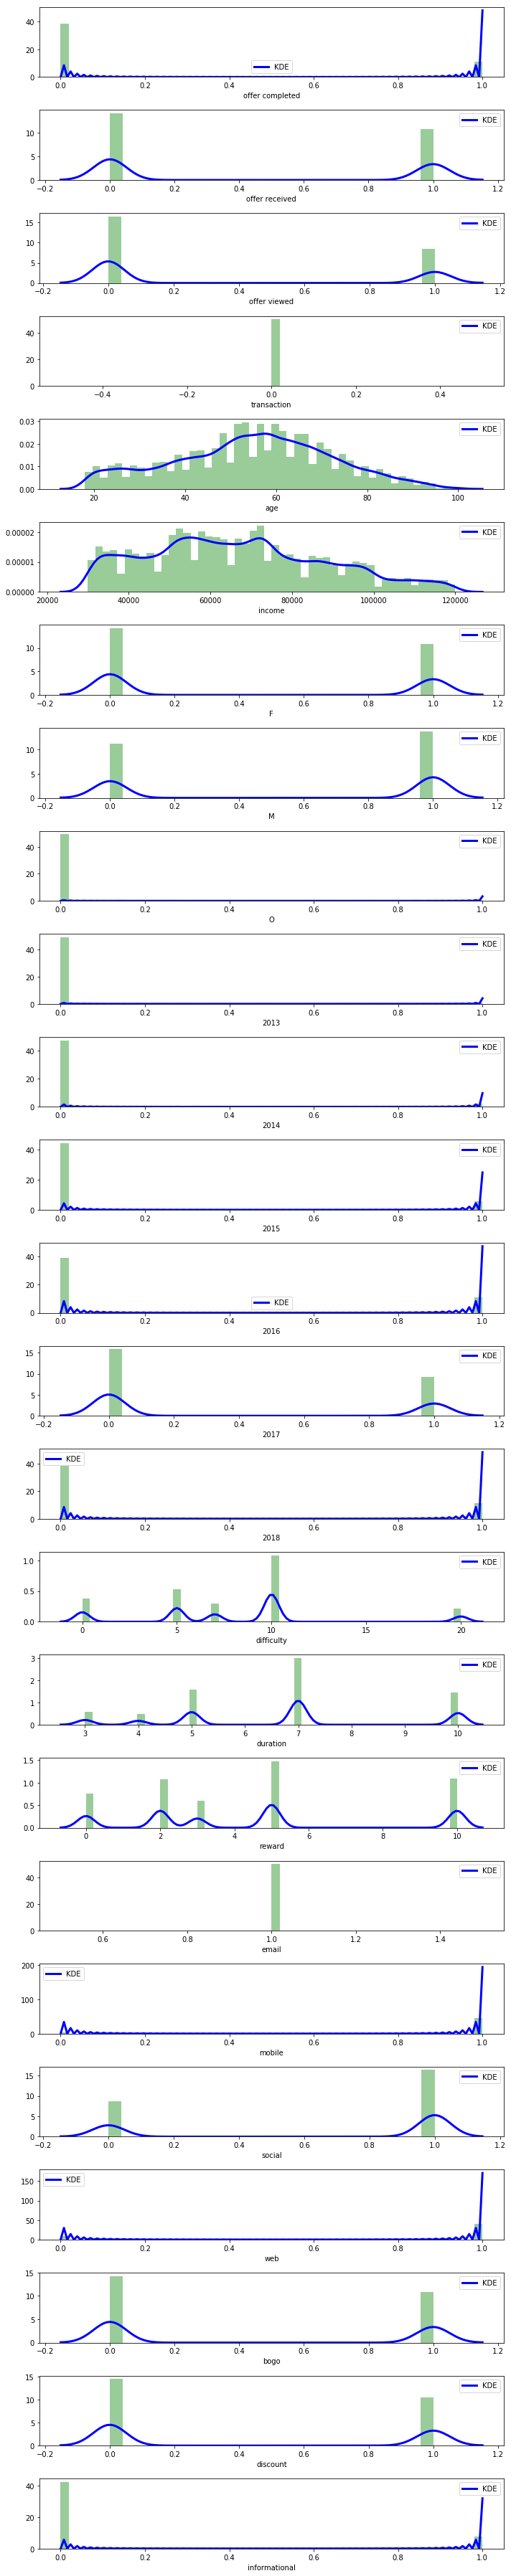

In [451]:
plt.figure(figsize=(10,50))
for i in range(len(df5.columns)):
    plt.subplot(25,1,i+1)
    sns.distplot(df5[df5.columns[i]],kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"g"})
    #plt.tile(df5.columns[i])
plt.tight_layout()

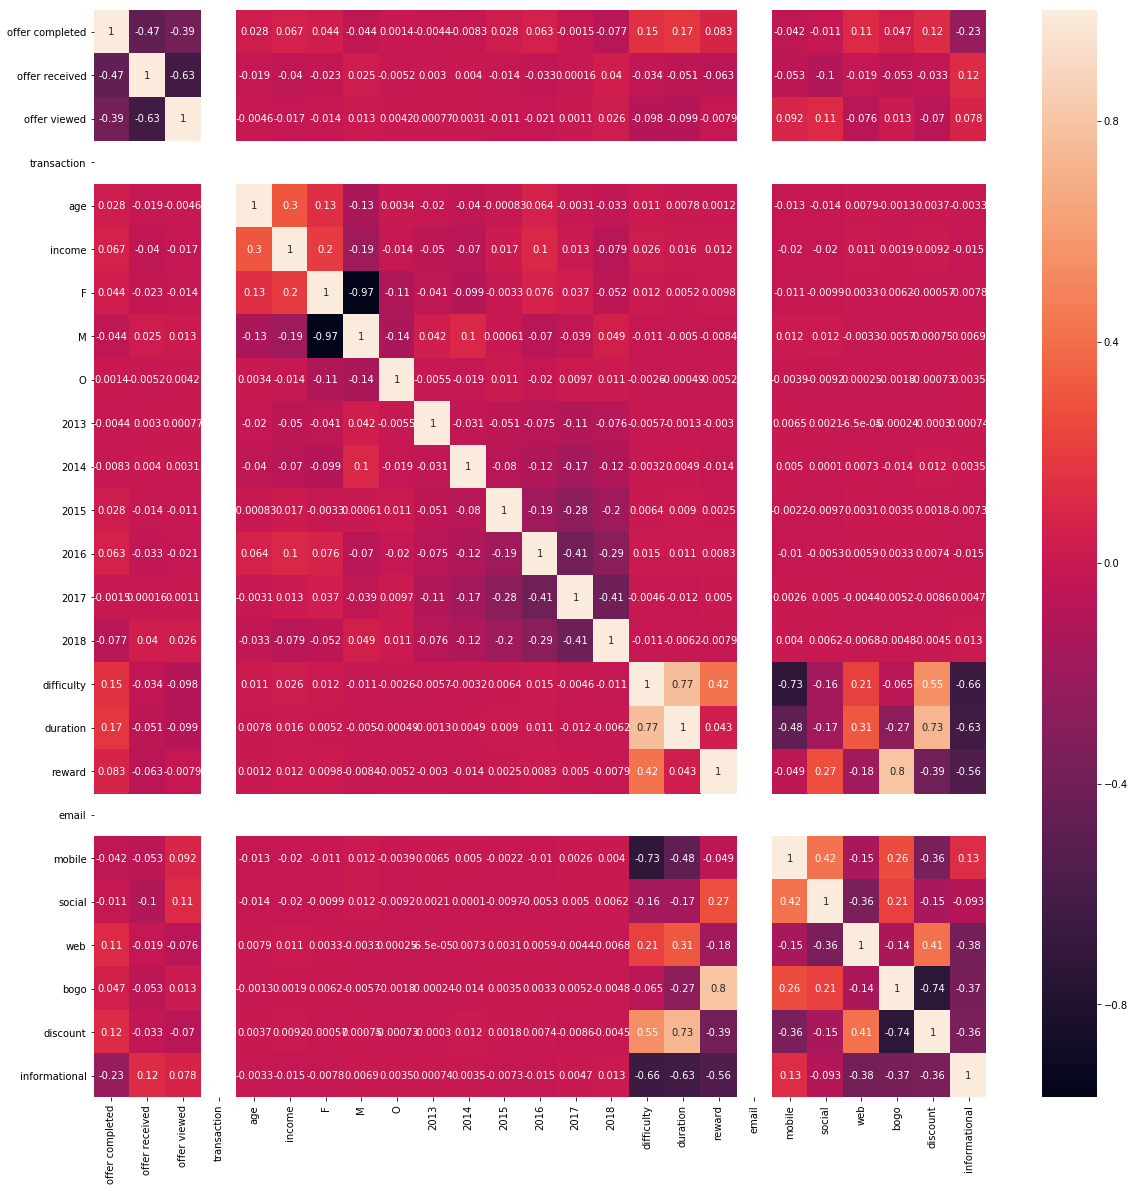

In [452]:
correlations=df5.corr()
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(correlations,annot=True)

# KMeans

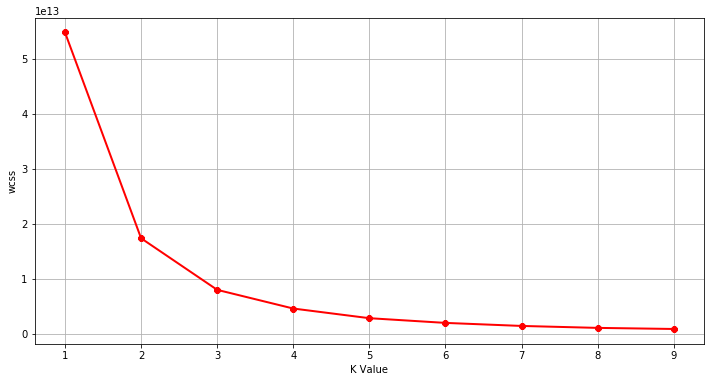

In [572]:
X1=df5.loc[:,['offer received','age','bogo','income']].values
from sklearn.cluster import KMeans
wcss=[]
for k in range (1,10):
    kmeans=KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,10),wcss,linewidth=2,color="red",marker="8")
plt.xlabel("K Value")
plt.ylabel("wcss")
plt.show()

In [573]:
model = KMeans(n_clusters=4, random_state=28).fit(X1)
kmeans_clusters = model.predict(X1)

In [579]:
df = X1.copy()
df['cluster'] = kmeans_clusters
sns.pairplot(df, hue='cluster')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [580]:
kmeans=KMeans(n_clusters=4)
label=kmeans.fit_predict(X1)
print(label)

[1 1 1 ..., 1 2 2]


In [581]:
print(kmeans.cluster_centers_)

[[  4.74763286e-01   4.83224649e+01   4.33452963e-01   3.90107666e+04]
 [  4.13783685e-01   6.29380918e+01   4.33266570e-01   9.99917607e+04]
 [  4.17749632e-01   5.74880699e+01   4.28224136e-01   7.57443501e+04]
 [  4.33545288e-01   5.23084075e+01   4.27243182e-01   5.74692101e+04]]


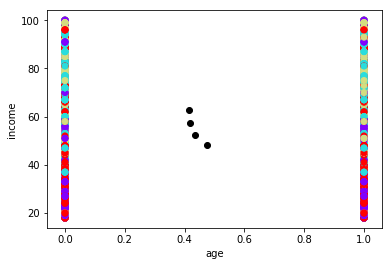

In [582]:
plt.scatter(X1[:,0],X1[:,1],c=kmeans.labels_,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='black')
plt.xlabel('age')
plt.ylabel('income')
plt.show()

In [ ]:
https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3

In [ ]:
https://towardsdatascience.com/customer-segmentation-and-acquisition-using-machine-learning-a219ce0ec139